In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

import project as proj
# import pointnets as ptn

%matplotlib notebook

np.set_printoptions(linewidth=120)

In [2]:
%matplotlib notebook

In [3]:
def save_fig(name):
    plt.savefig(f'figures/{name}.png')
    plt.savefig(f'figures/{name}.pdf')
    print(name, 'saved')

In [4]:
# root = r'D:\metrics'
os.environ['FOUNDATION_SAVE_DIR'] = r'D:\completed'
os.environ['FOUNDATION_DATA_DIR'] = r'D:\local_data'

In [5]:
ds = '3ds'
ds = 'mpi'

In [6]:
if ds == '3ds':
    dataset = trn.get_dataset('3dshapes', train=None, labeled=True)
    lbls = dataset.labels.clone()
else:
    dataset = trn.get_dataset('mpi3d', category='toy', train=None, labeled=True)
    lbls = dataset.get_labels()
len(dataset), lbls.shape

Loading dataset: mpi3d
dataroot: D:\local_data
train: None
labeled: True
din: (3, 64, 64) (by default)
dout: 7 (by default)
category: toy
Found FID Stats


(1036800, torch.Size([1036800, 7]))

In [7]:
# dataset = trn.get_dataset('mpi3d', category='toy', train=True, labeled=True)

In [8]:
dataset.factor_order

['object_color',
 'object_shape',
 'object_size',
 'camera_height',
 'background_color',
 'horizonal_axis',
 'vertical_axis']

In [9]:
# M = trn.Run_Manager()

In [10]:
# M.show()

In [11]:
# M.filter(lambda r: '3ds-' in r.name)
# M.show()

In [12]:
# M.load_into('results.pth.tar')

In [13]:
idx = 2

In [14]:
# run = M[idx]
run = util.tdict()
run.latent_params = {}
# run.name, run.results.keys()

In [15]:
# rname = 'mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023'
if ds == '3ds':
    rname = '3ds-ae-12b1_0052-6286534-00_200429-030431'
    rname_final = '3ds-ae-12b1-conv_0005-6337809-01_200509-120419'
else:
    rname = 'mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023'
    rname_final = rname

In [16]:
results = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], rname_final, 'final.pth.tar'))
stats = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], rname, 'results.pth.tar'))
results.keys()

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])

In [17]:
out = results['out']

In [18]:
A = trn.get_config()
A.din = (3,64,64)
A.dout = (3,64,64)

# model, = trn.load('mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023', get_data=None, A=A, update_config=True)
model, = trn.load(rname, config=A, get_data=None, update_config=True)
print(model)

load successful


calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loaded D:\completed\mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023\checkpoint_100000.pth.tar
Set dataroot to: D:\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [10]: 64
    [11]: 64
    factors (type=list): 
    [0]: 1
    [1]: 1
    [2]

    din: (64, 16, 16)
    dout: (3, 64, 64) (in parent)
    up_type: bilinear (in parent)
    norm: group (in parent)
    nonlin: elu (in parent)
    output_nonlin --> nonlin: elu (in parent)
    residual: False (by default)
      conv_kwargs (type=dict): 
  Creating branches[7] (type=norm-ada-in)
    style_dim --> din: 1
    features: 64
    pixelwise: False (by default)
    noise_dim: 64 (by default)
    Creating net (type=mlp) (mod=normal) (in parent)
      latent_dim: 64
      min_log_std: None (by default)
      input_dim --> din: 1
      output_dim --> dout: 128
      hidden_dims --> branch_hidden (type=list): 
[0]: 64
[1]: 128
      nonlin: elu (in parent)
      output_nonlin: None (in parent)
  Creating layers[7] (type=deconv-layer)
    in_channels: 64
    out_channels: 64
    factor: 1
    size: None (by default)
    kernel_size: None (by default)
    stride: 1 (by default)
    padding: 1 (by default)
    dilation: 1 (by default)
    output_padding: 0 (by default)
    din: (64

)


In [19]:
# out = run.results['out']
# out.keys()

In [20]:
# ckpt = torch.load(os.path.join(run.path, 'checkpoint_100000.pth.tar'))
# ckpt.keys()

In [21]:
# mstate = ckpt['model_state']
# mstate.keys()

In [22]:
# # bad = ["dec.layers.2.deconv.1.weight", "dec.layers.2.deconv.1.bias", "dec.layers.5.deconv.1.weight", "dec.layers.5.deconv.1.bias", "dec.layers.8.deconv.1.weight", "dec.layers.8.deconv.1.bias", "dec.layers.10.deconv.1.weight", "dec.layers.10.deconv.1.bias"]
# bad = ["dec.layers.2.deconv.1.weight", "dec.layers.2.deconv.1.bias", "dec.layers.5.deconv.1.weight", "dec.layers.5.deconv.1.bias", "dec.layers.8.deconv.1.weight", "dec.layers.8.deconv.1.bias", "dec.layers.10.deconv.1.weight", "dec.layers.10.deconv.1.bias"]

# fix = []
# for bname in bad:
#     f = bname.split('.')
#     f = f[:4] + f[5:]
#     f = '.'.join(f)
#     fix.append(f)

# # bad = ["dec.deconv.0.deconv.1.weight", "dec.deconv.0.deconv.1.bias", "dec.deconv.1.deconv.1.weight", "dec.deconv.1.deconv.1.bias", "dec.deconv.2.deconv.1.weight", "dec.deconv.2.deconv.1.bias", "dec.deconv.3.deconv.1.weight", "dec.deconv.3.deconv.1.bias", "dec.deconv.4.deconv.1.weight", "dec.deconv.4.deconv.1.bias"]
# # fix = ["dec.deconv.0.deconv.weight", "dec.deconv.0.deconv.bias", "dec.deconv.1.deconv.weight", "dec.deconv.1.deconv.bias", "dec.deconv.2.deconv.weight", "dec.deconv.2.deconv.bias", "dec.deconv.3.deconv.weight", "dec.deconv.3.deconv.bias", "dec.deconv.4.deconv.weight", "dec.deconv.4.deconv.bias"]


In [23]:
# X = out['original']
# X.shape

In [24]:


# for bname, fname in zip(bad, fix):
#     if bname in mstate['model']['parameters']:
#         mstate['model']['parameters'][fname] = mstate['model']['parameters'][bname]
#         del mstate['model']['parameters'][bname]
#         print(f'replaced {bname} with {fname}')

In [25]:
# model.load_state_dict(mstate)

<IPython.core.display.Javascript object>


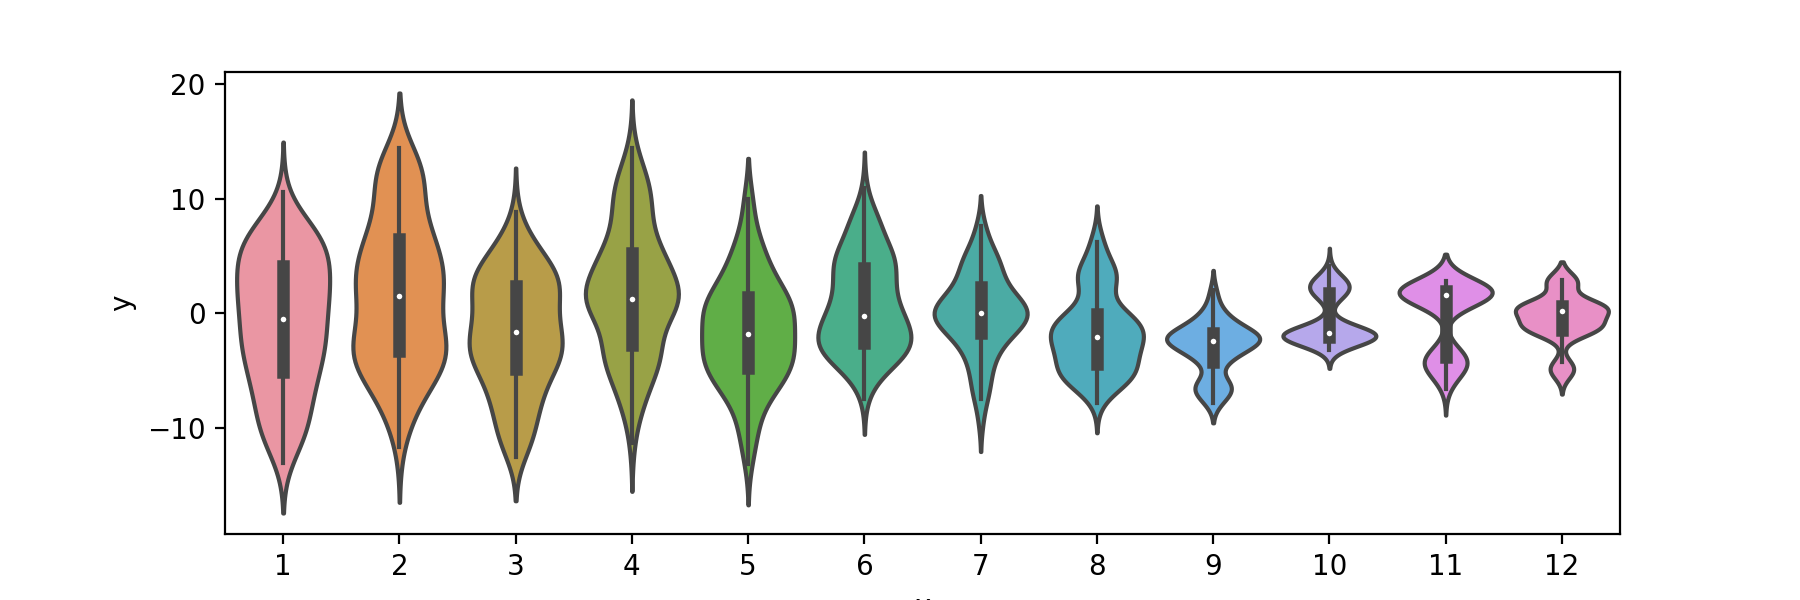

In [26]:
saved_Q = stats['out']['latent']
if isinstance(saved_Q, distrib.Normal):
    saved_Q = saved_Q.mean
saved_Q = saved_Q.cpu()
fig, ax = util.plot_distribs(saved_Q, figsize=(9, 3))
pass

In [68]:
# with torch.no_grad():
#     g = model.generate(64)
# util.show_imgs(g)
# pass

In [27]:
idx = 0

In [59]:

if ds == '3ds':
    target = 'floor_hue'
#     target = 'wall_hue'
#     target = 'object_hue'
    
    
    lbl_dims = {'floor_hue':0, 'wall_hue':1, 'object_hue':2}
    color_dims = {'object_hue': [6,7], 'wall_hue':[8,9], 'floor_hue':[10,11]}
#     color_dims = {'object_hue': [4,5], 'wall_hue':[7,8], 'floor_hue':[9,10]}
    dims = color_dims[target]
    ldim = lbl_dims[target]
    bidx = 3

else:
    target = 'object_color'
    # target = 'background_color'
    
    color_dims = [
        {'object_color':[8,11], 'background_color':[9,10],},
    ]
    lbl_dims = {'object_color':0, 'background_color':1,}
    ldim = lbl_dims[target]
    dims = color_dims[idx][target]
    bidx = 48
ldim, dims

(0, [8, 11])

In [60]:
H = 16
W = 16
# H,W = 8,8

<IPython.core.display.Javascript object>


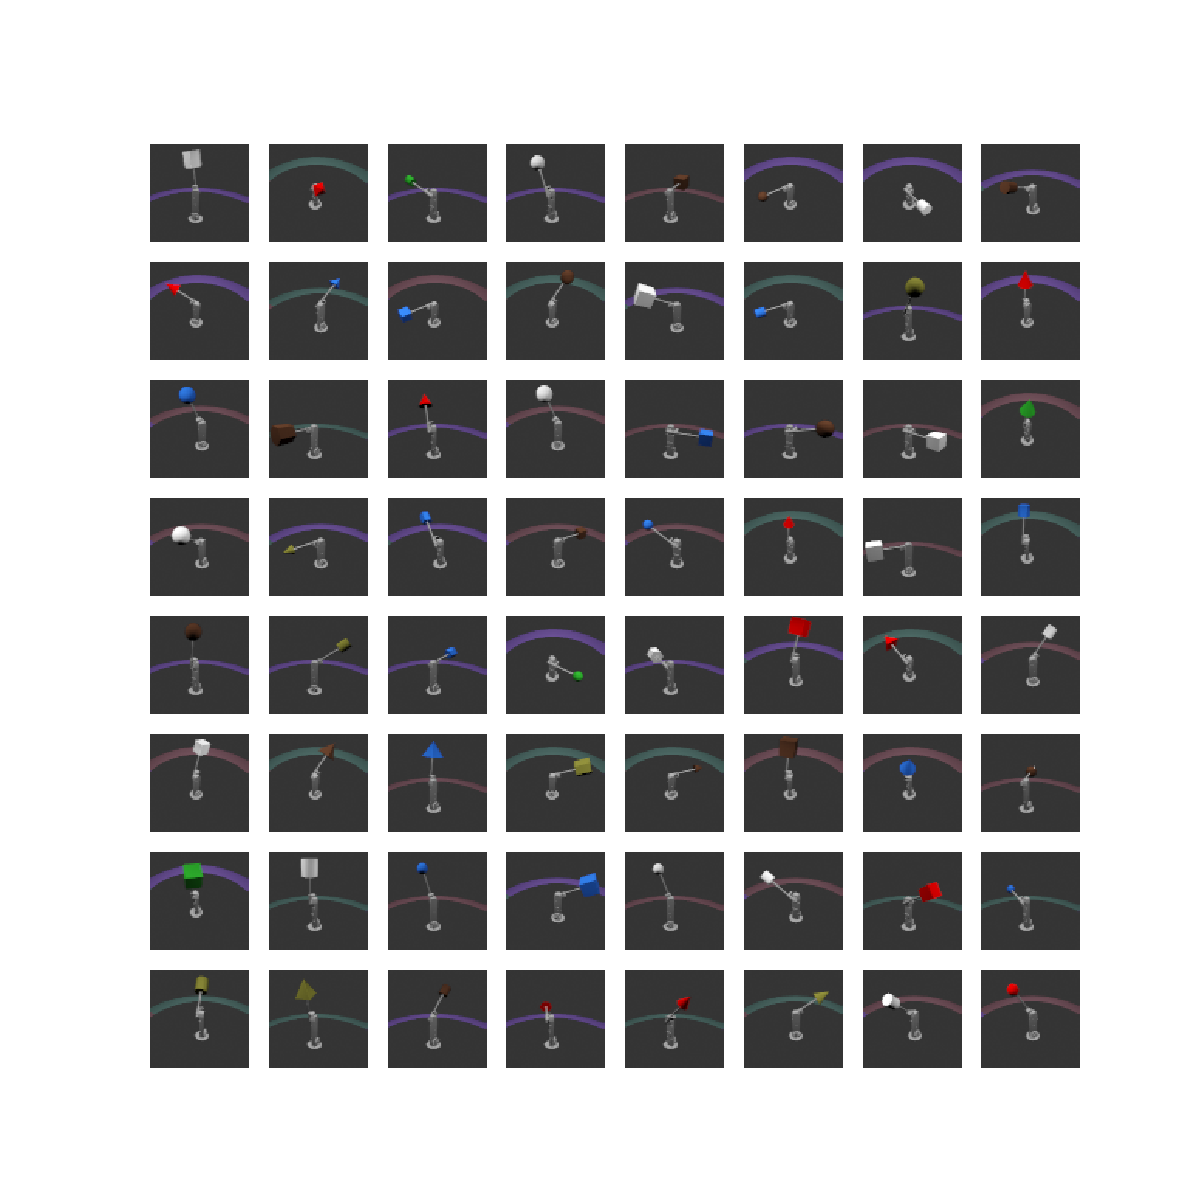

In [61]:
util.show_imgs(out['original'][64:])
pass

In [62]:
np.mgrid[1:0:H*-1j]

array([1.        , 0.93333333, 0.86666667, 0.8       , 0.73333333, 0.66666667, 0.6       , 0.53333333, 0.46666667,
       0.4       , 0.33333333, 0.26666667, 0.2       , 0.13333333, 0.06666667, 0.        ])

In [63]:
with torch.no_grad():
    init_Q = model.encode(out['original'][bidx:bidx+1].cuda())
    if isinstance(init_Q, distrib.Distribution):
        init_Q = init_Q.mean
    init_Q = init_Q[0].cpu()
init_Q.shape

torch.Size([12])

In [64]:
Q = saved_Q
deltas = torch.from_numpy(np.mgrid[1:0:H*-1j,0:1:W*1j]).float()
mn, mx = Q[:,dims].min(0)[0], Q[:,dims].max(0)[0]
print(mn, mx)
mn, mx = mn.view(-1,1,1), mx.view(-1,1,1)
deltas = deltas * (mx-mn) + mn
deltas = deltas.permute(1,2,0).view(-1,2)
# deltas.shape
vecs = init_Q.unsqueeze(0).expand(H*W,-1).clone()
# vecs = Q[1].unsqueeze(0).expand(H*W,-1).clone()
vecs[:,dims] = deltas
vecs = vecs.view(H,W,-1).permute(1,0,2).contiguous().view(H*W,-1)
vecs.shape

tensor([-7.7837, -5.4380]) tensor([2.0139, 2.9180])


torch.Size([256, 12])

In [65]:
vecs = torch.from_numpy(vecs.numpy()[::-1].copy())

In [66]:
with torch.no_grad():
    raw = model.decode(vecs.to(model.device)).cpu()
raw.shape

torch.Size([256, 3, 64, 64])

<IPython.core.display.Javascript object>


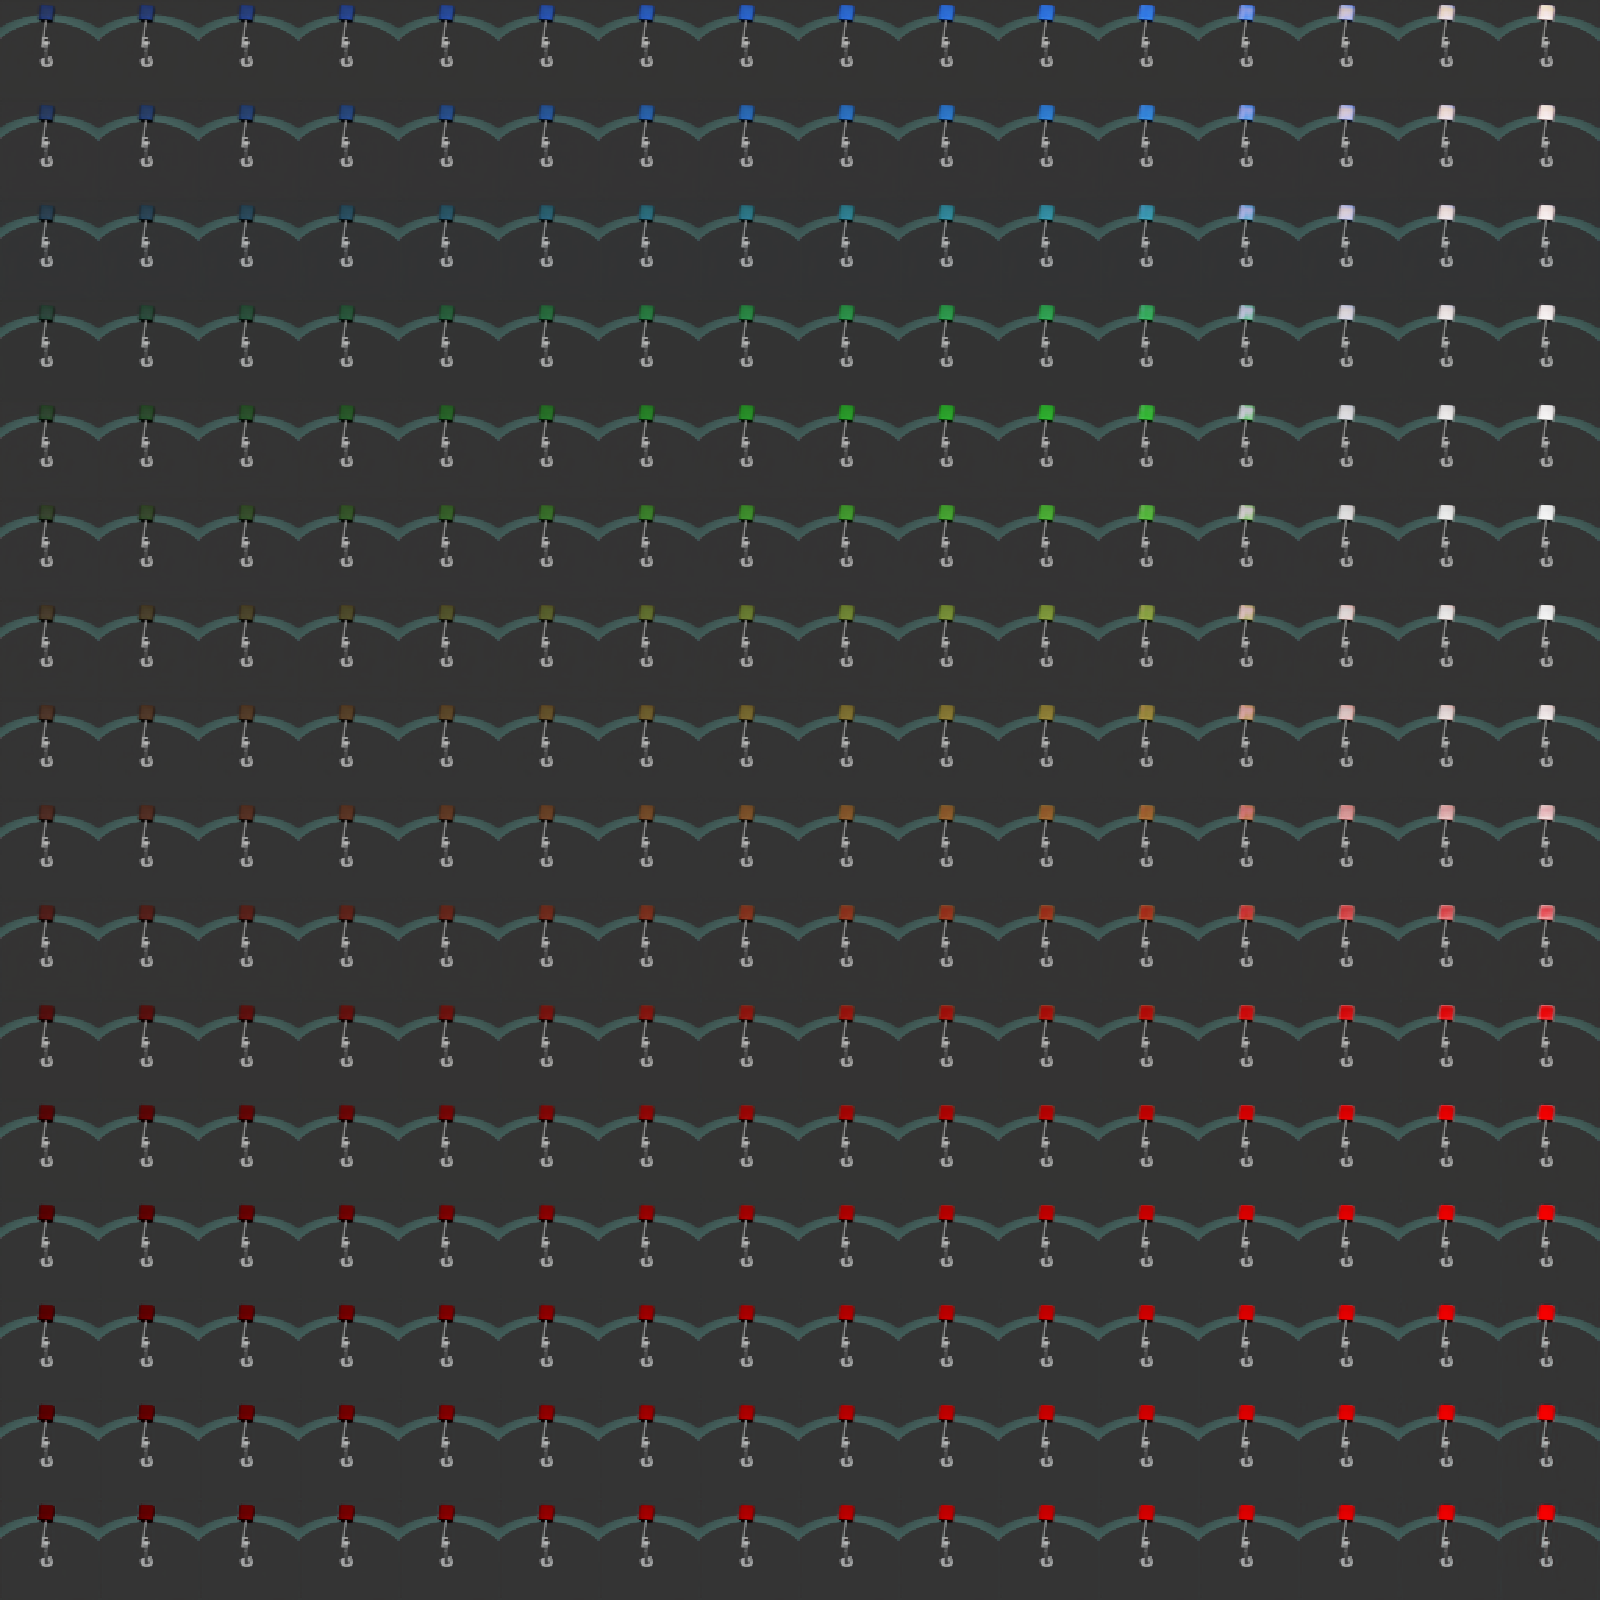

In [67]:
util.show_imgs(raw, H=H,W=W, figsize=(8,8))
border, between = 0.00, 0.00
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)
pass

In [55]:
# save_fig(f'{ds}_2dtraversal')

mpi_2dtraversal saved


In [98]:
raw.shape

torch.Size([256, 3, 64, 64])

In [74]:
if ds == '3ds':
    mids = raw[:,:,40:44, 30:34]
# mids = raw[:,:,39:43, 42:46] # object color
else:
    mids = raw[:,:,4:8,26:34]
mids.shape

torch.Size([256, 3, 4, 8])

<IPython.core.display.Javascript object>


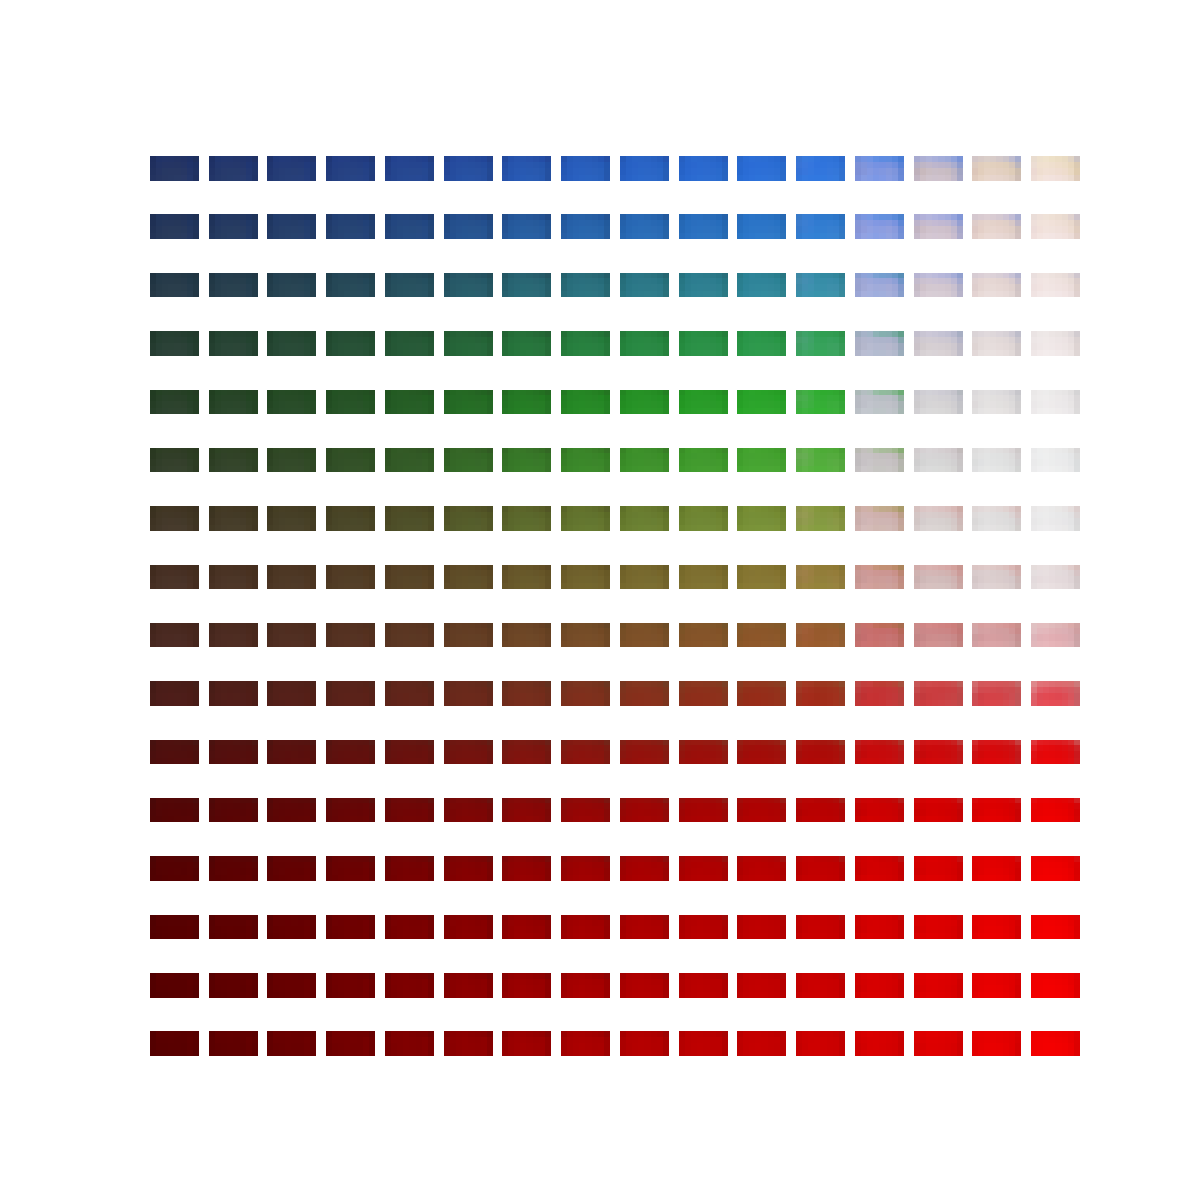

In [75]:
util.show_imgs(mids)
pass

In [101]:
# save_fig(f'{ds}_mids_large')

3ds_mids_large saved


In [102]:
clrs = mids.mean(-1).mean(-1)
clrs.shape

torch.Size([256, 3])

In [121]:
tmids = X[10:20,:,40:44,30:34]
tmids.shape

torch.Size([10, 3, 4, 4])

<IPython.core.display.Javascript object>


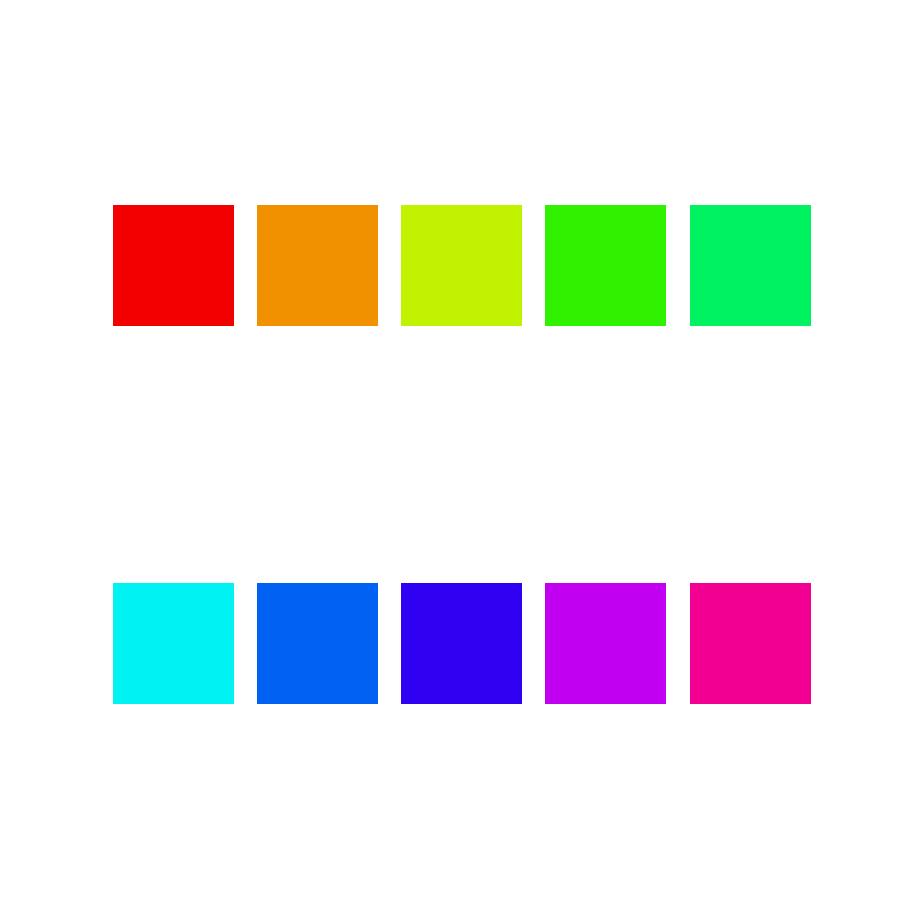

In [122]:
util.show_imgs(tmids)
pass

In [124]:
# save_fig(f'{ds}_training_colors')

3ds_training_colors saved


In [125]:
tclrs = tmids.mean(-1).mean(-1)
tclrs.shape

torch.Size([10, 3])

In [126]:
cat_styles = {'gen':{'color':'k', 'alpha':0.3, 'lw':1}, 
              
#                         'train':{'color':'k', 'lw':4, 'alpha':0.8},
                    }

cats = []
# cats = cats +['train']*len(tclrs)

for i, c in enumerate(tclrs):
    c = tuple(c.cpu().numpy())
    cat = f'{i}'
    cat_styles[cat] = {'color':c, 'lw':5, 'alpha': 1}
    cats.append(cat)

cats = cats + ['gen']*len(clrs)

<IPython.core.display.Javascript object>


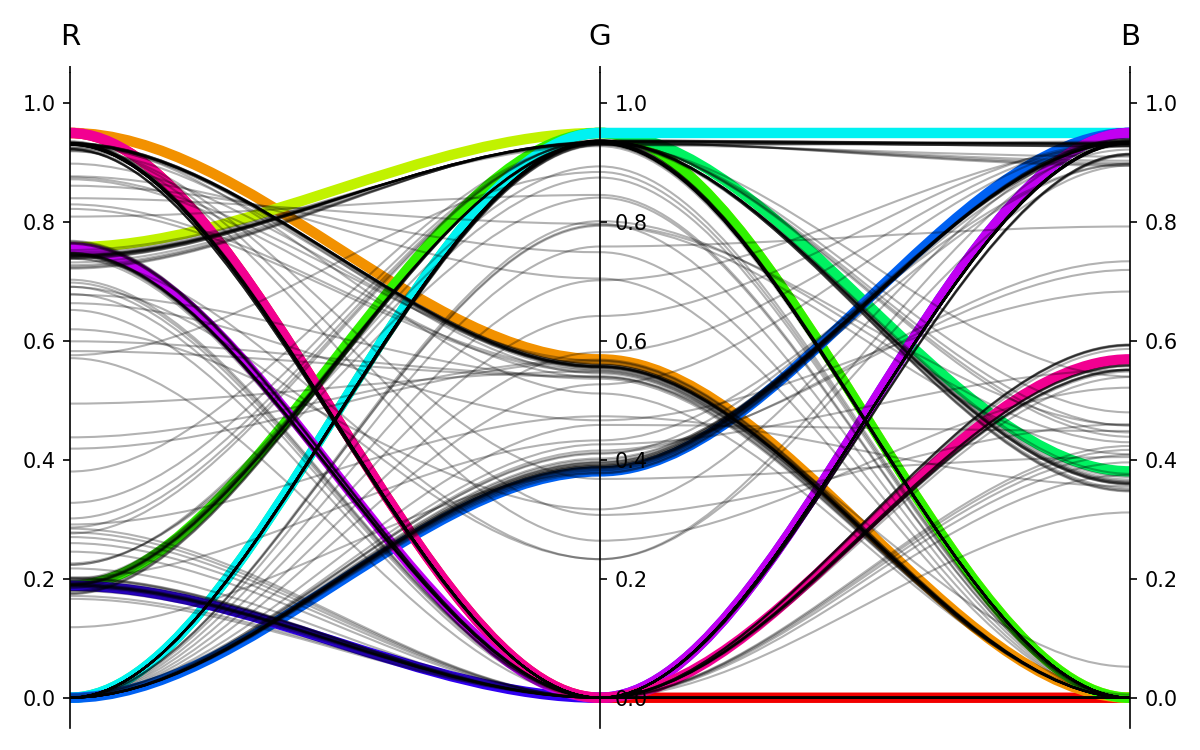

In [132]:
util.plot_parallel_coords(torch.cat([tclrs,clrs]), dim_names=['R','G','B'], 
                     categories=cats, include_legend=False,
                     mins=torch.zeros(3), maxs=torch.ones(3), font_size=100,
                    cat_styles=cat_styles)
plt.tight_layout()
pass

In [133]:
save_fig(f'{ds}_spread')

3ds_spread saved


In [134]:
raw.shape

torch.Size([256, 3, 64, 64])

In [135]:
vecs.shape

torch.Size([256, 12])

In [165]:
with torch.no_grad():
    rimg, rq = model(raw.to(model.device), ret_q=True)
    if isinstance(rq, distrib.Normal):
        rq = rq.mean
    rimg, rq = rimg.cpu(), rq.cpu()
    rd = rq[:,dims]
rimg.shape, rq.shape

(torch.Size([256, 3, 64, 64]), torch.Size([256, 12]))

In [166]:
# fix order
rd = torch.from_numpy(rd.numpy()[::-1].copy())
rd = rd.view(H,W,-1).permute(1,0,2).contiguous().view(H*W,-1)

In [167]:

rd.shape, deltas.shape

(torch.Size([256, 2]), torch.Size([256, 2]))

<IPython.core.display.Javascript object>


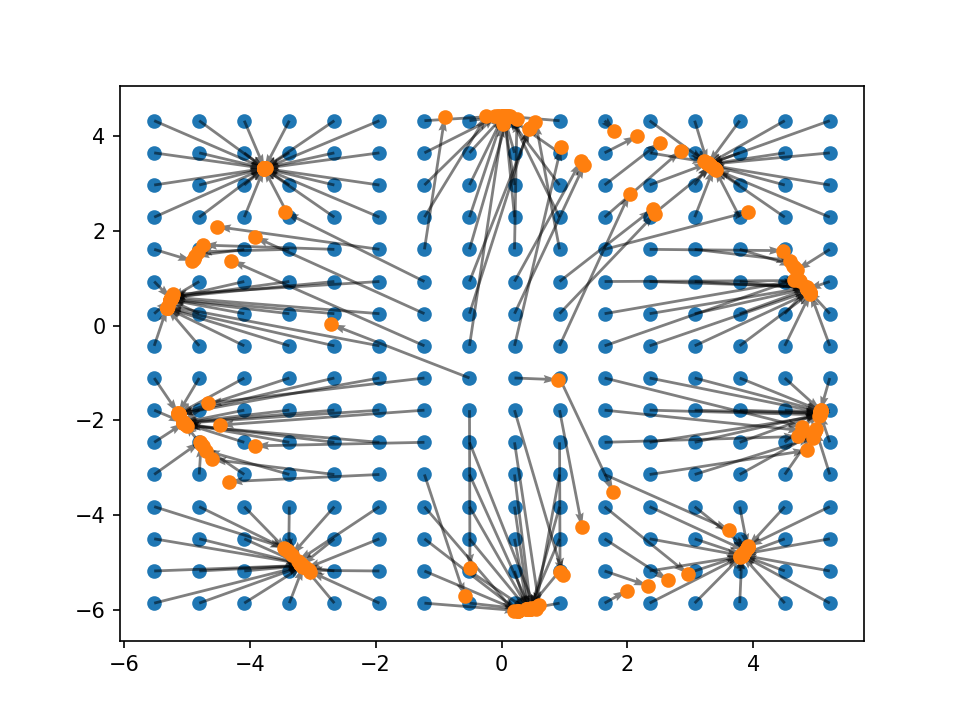

In [168]:
plt.figure()
plt.scatter(*deltas.t())
dr = rd - deltas
# sel = slice(0,-1)
plt.quiver(*deltas.t(), *dr.t(),angles='xy', scale_units='xy', scale=1, alpha=0.5)# scale=.01)
plt.scatter(*rd.t())
pass

In [169]:
save_fig(f'{ds}_recovery')

3ds_recovery saved


<IPython.core.display.Javascript object>


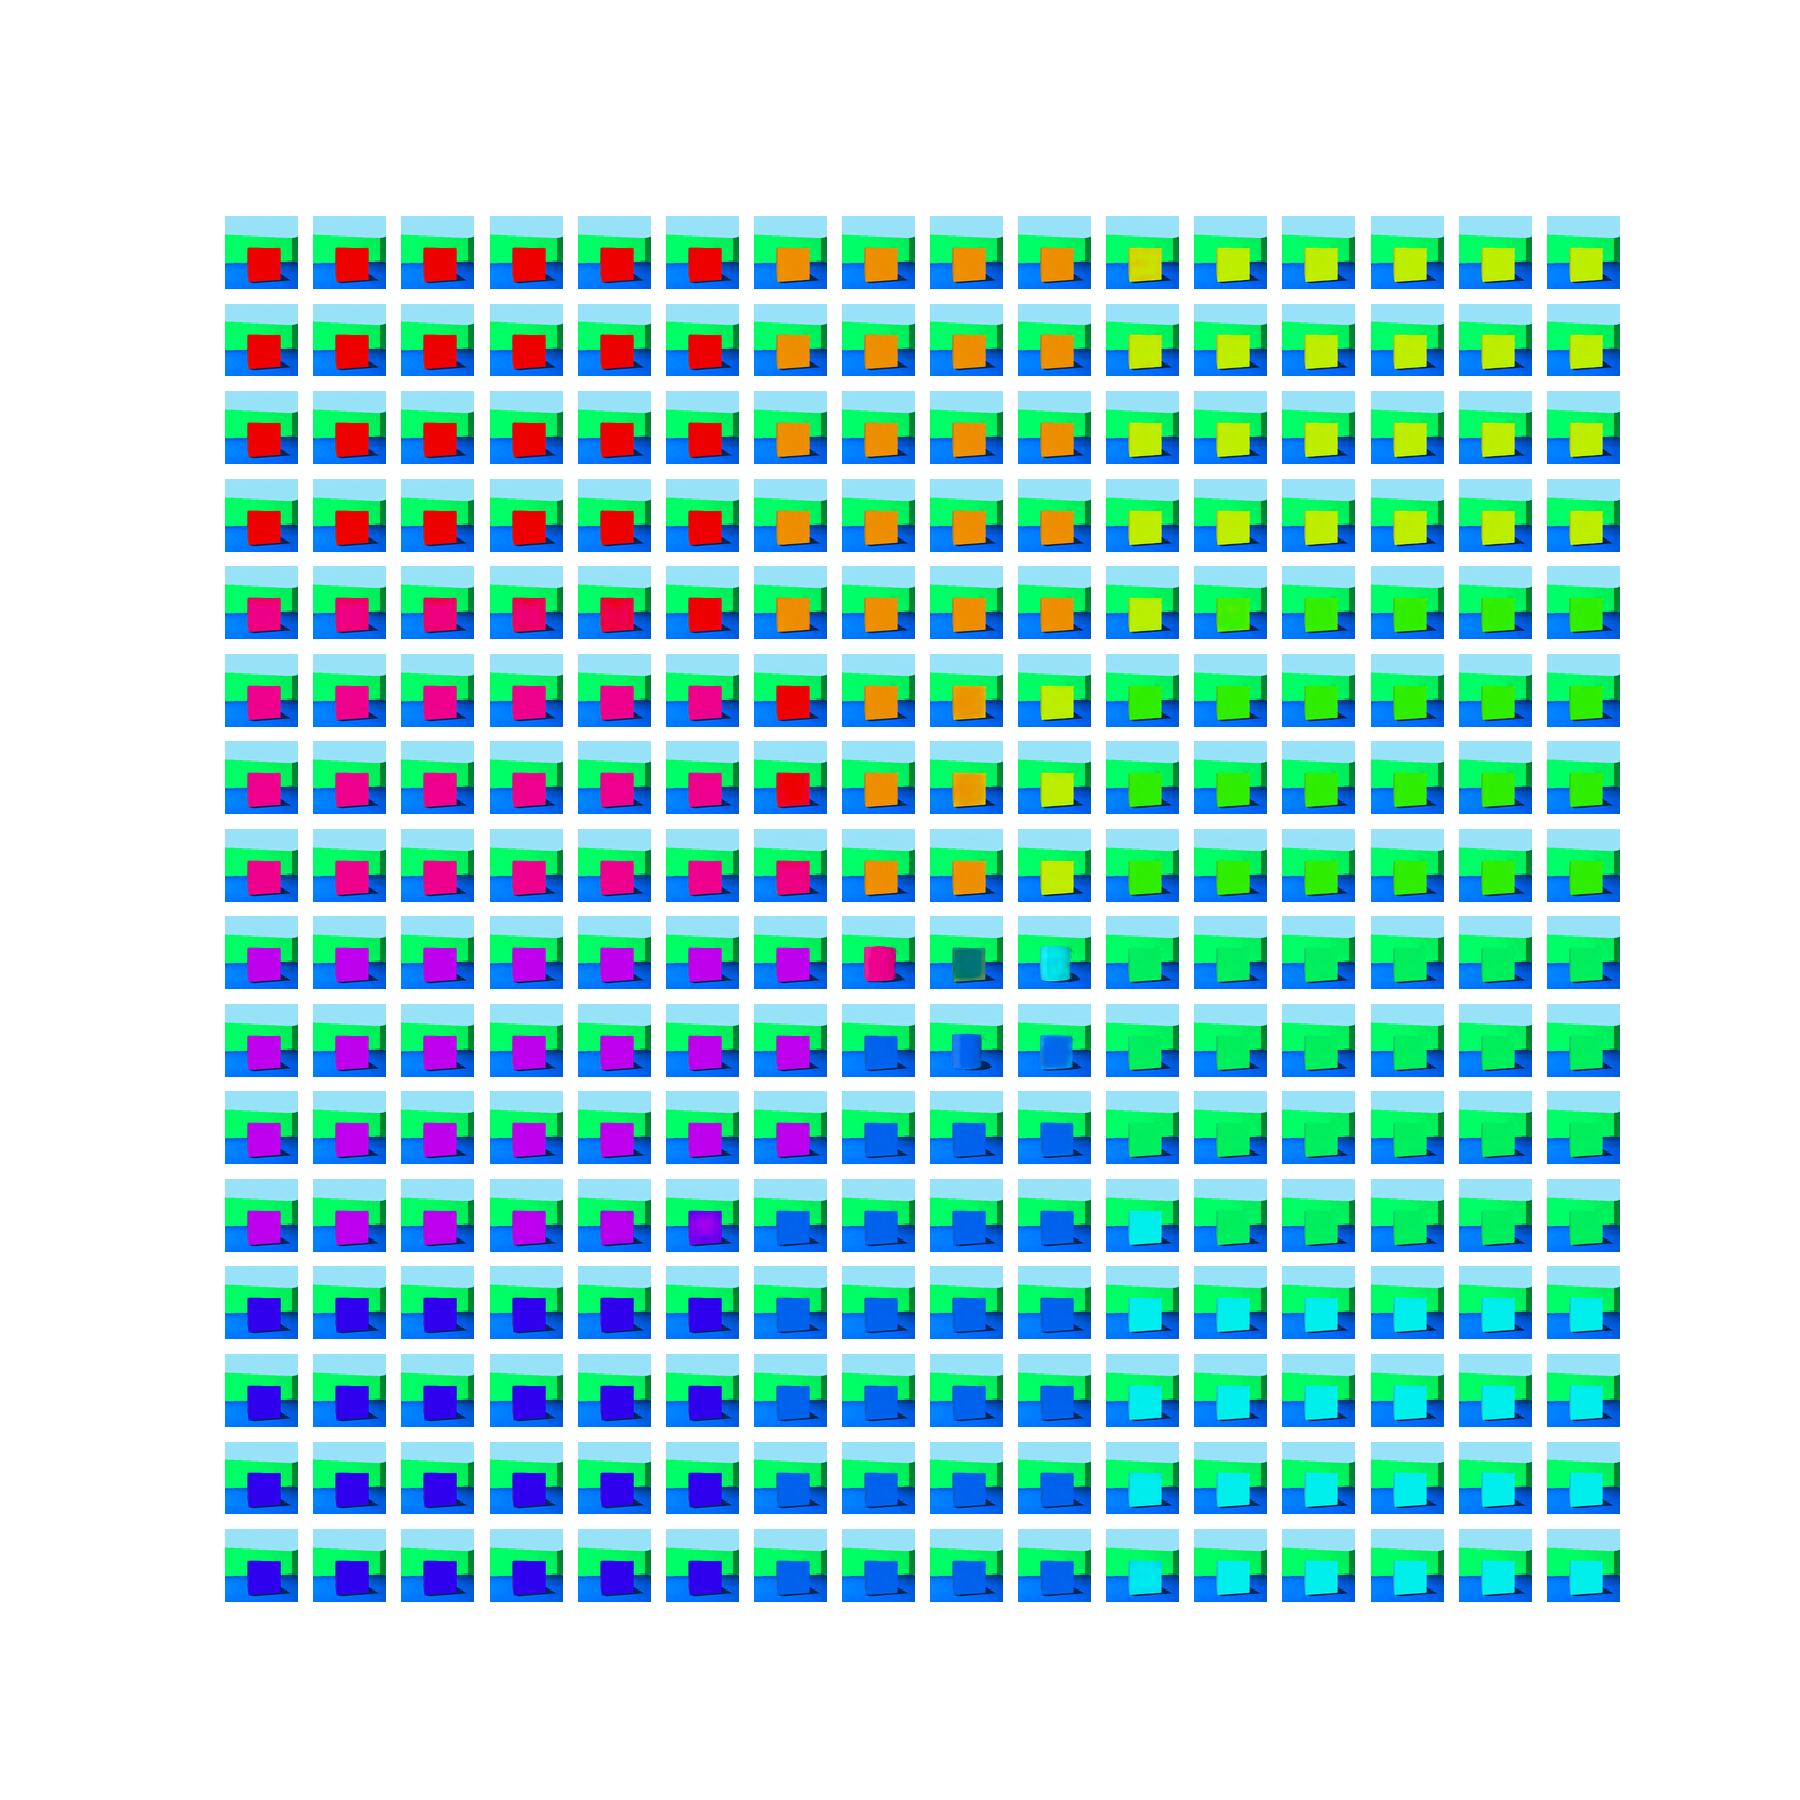

In [170]:
util.show_imgs(rimg, H=H,W=W, figsize=(12,12))
pass

In [171]:
# save_fig(f'{ds}_recoverd_large')

3ds_recoverd_large saved


In [172]:
raw.shape

torch.Size([256, 3, 64, 64])

In [173]:
rmids = rimg[:,:,40:44, 30:34]
rmids.shape

torch.Size([256, 3, 4, 4])

<IPython.core.display.Javascript object>


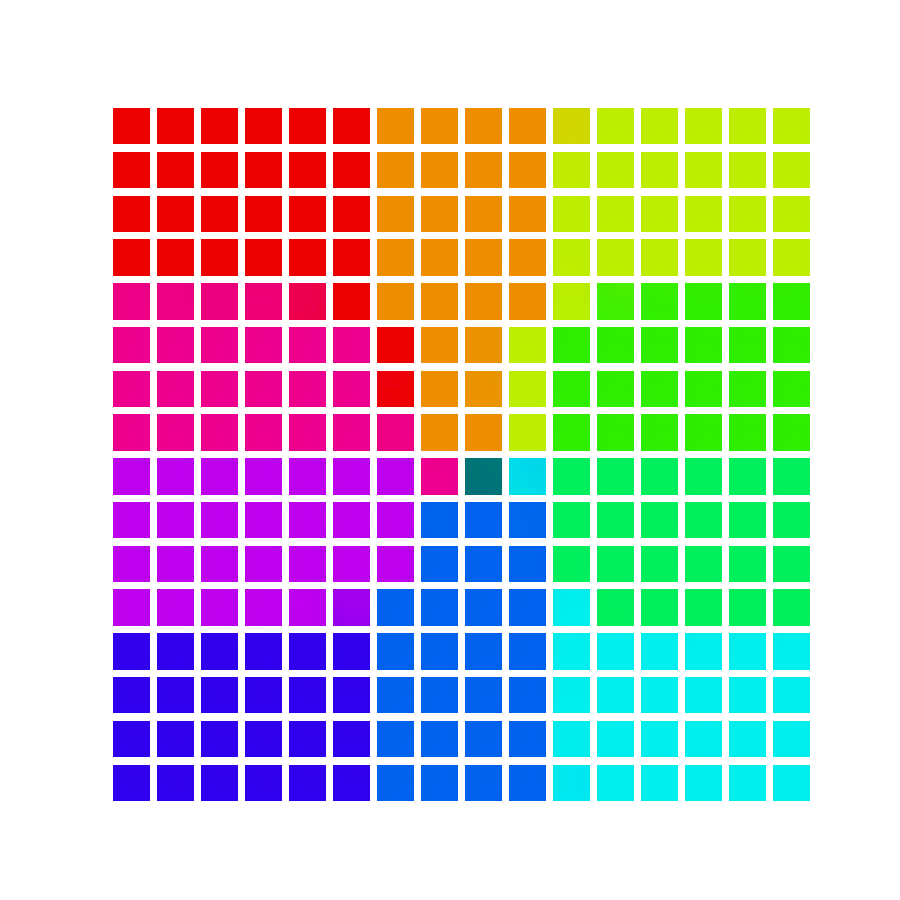

In [174]:
util.show_imgs(rmids)
pass

In [175]:
# save_fig(f'{ds}_recoverd_large_mids')

3ds_recoverd_large_mids saved


In [87]:
N = 10
D = dataset.factor_sizes[ldim]
U = sum(dataset.factor_sizes[ld] for ld in lbl_dims.values())
D, U

(6, 12)

In [89]:
torch.manual_seed(3)
picks = torch.randint(np.product(dataset.factor_sizes).item() // U, size=(N,))
picks

tensor([26986, 65048, 18937,  8067, 82360, 23880, 32640, 53525, 54781, 40339])

In [90]:
dataset.factor_sizes

[6, 6, 2, 3, 3, 40, 40]

In [91]:
dens = torch.from_numpy(np.cumprod([1] + dataset.factor_sizes[:0:-1],0)[::-1].copy()).long()
dens

tensor([172800,  28800,  14400,   4800,   1600,     40,      1])

In [92]:
ldim

0

In [93]:
fixed = torch.stack([picks//(15*4)%8, picks//(15)%4, picks%15],1).unsqueeze(1).expand(N,D,-1)
var = torch.randint(10,size=(N,3)).unsqueeze(1).expand(N,D,-1).contiguous()
delta = torch.arange(D).unsqueeze(0).expand(N,-1)
var.shape, fixed.shape, delta.shape

var[...,ldim] = delta

cls = torch.cat([var, fixed], -1).view(N*D,-1)
cls.shape

torch.Size([60, 6])

In [82]:
inds = cls @ dens.view(-1)
inds

RuntimeError: size mismatch, [60 x 6], [7] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:193

In [217]:
X, Y = dataset[inds]
X.shape, Y.shape

(torch.Size([100, 3, 64, 64]), torch.Size([100, 6]))

<IPython.core.display.Javascript object>


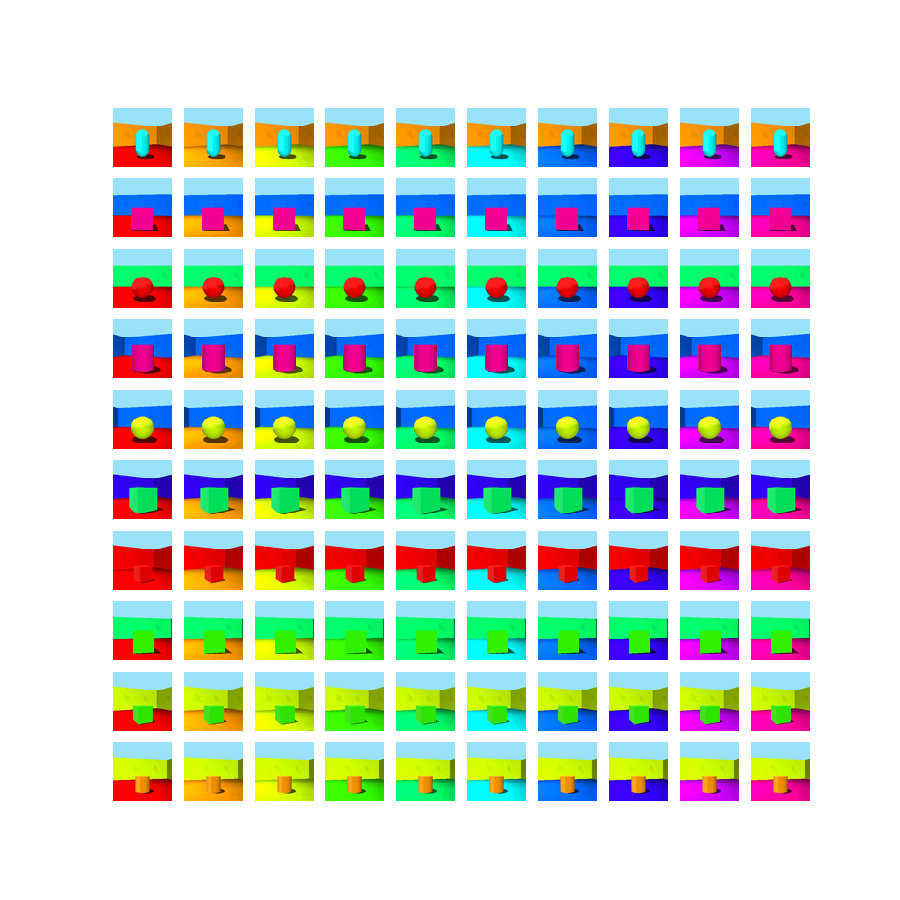

In [218]:
util.show_imgs(X)
pass

In [219]:
# save_fig(f'{ds}_object_hues')

In [220]:
x = X.clone()

In [221]:
bidx = torch.randperm(len(dataset))[:10000].view(-1,100)
colors = []
for b in bidx:
    X = dataset[b][0]
    with torch.no_grad():
        c = model.encode(x.to(model.device)).cpu()
    colors.append(c[:,dims])
colors = torch.cat(colors)
colors.shape

torch.Size([10000, 2])

In [222]:
bias = colors.mean(0)
r = colors.norm(dim=1).mean()
t = torch.linspace(0,2*np.pi, 1000)
circx = r*torch.cos(t) + bias[0]
circy = r*torch.sin(t) + bias[1]
if target not in run.latent_params:
    run.latent_params[target] = r, bias
run.latent_params.keys()

dict_keys(['object_hue', 'wall_hue', 'floor_hue'])

In [223]:
with torch.no_grad():
    qcol = model.encode(x.to(model.device)).cpu()
qcol = qcol.view(N,D,-1)[...,dims]
qcol.shape

torch.Size([10, 10, 2])

<IPython.core.display.Javascript object>


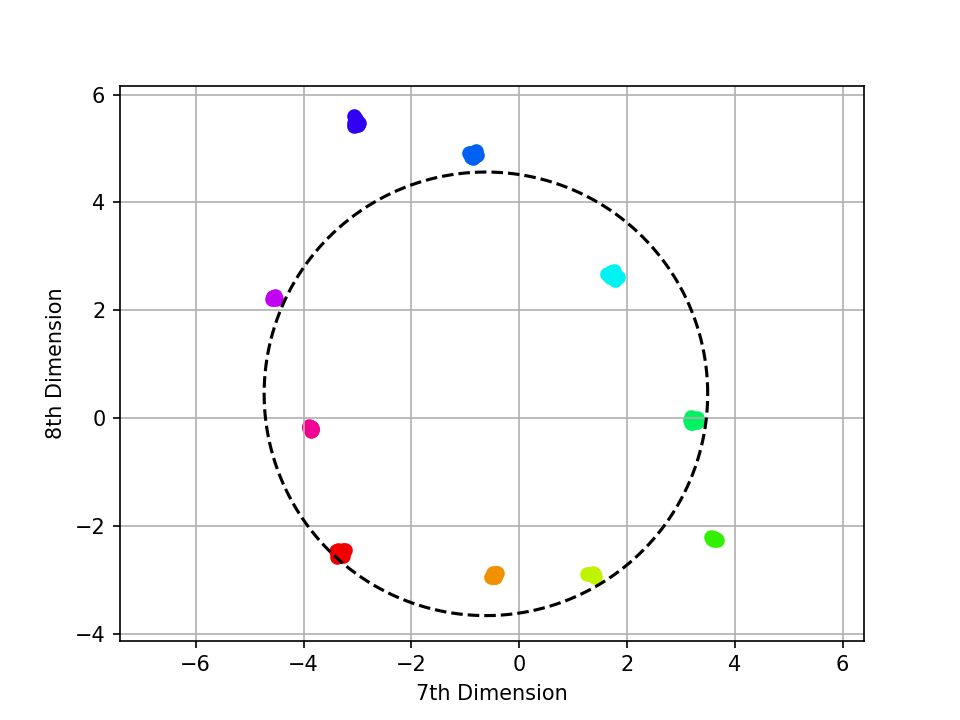

In [224]:
plt.figure()
# plt.scatter(*colors.t(), marker='.', color='k')
plt.plot(circx, circy, color='k', ls='--')
for i,q in enumerate(qcol.permute(1,0,2)):
#     v = q.mean(0)
#     v = 1.1*(v-bias) + bias
#     plt.text(*v,str(i+1))
    plt.scatter(*q.t(),color=tclrs[i])
#     plt.plot(*q[0].t(),marker='o', color='C{}'.format(i%10))
#     plt.plot(*q.t(), color='C{}'.format(i%10))
# plt.arrow(0,0,*bias,ls='--', color='r', head_width=.2)
plt.axis('equal')
plt.xlabel('7th Dimension')
plt.ylabel('8th Dimension')
plt.grid()

In [73]:
save_fig(f'{ds}_object_hues_space')

3ds_object_hues_space saved


In [234]:
# from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
# imagebox = OffsetImage(arr_lena, zoom=0.2)
# ab = AnnotationBbox(imagebox, (0.4, 0.6))
# ax.add_artist(ab)

In [235]:
run.latent_params

{'object_hue': (tensor(4.8795), tensor([-0.1714, -0.7104])),
 'wall_hue': (tensor(3.8209), tensor([-0.1941,  0.1256])),
 'floor_hue': (tensor(4.1149), tensor([-0.6159,  0.4488]))}

In [225]:
extra_dims = {
    'orientation': 1,
    'shape': 3,
    'size': 4,
}
edims = [1,3,4]

# for e,d in extra_dims.items():
#     run.latent_params[e] = Q.min(0)[0][d], Q.max(0)[0][d]
run.latent_params

{'object_hue': (tensor(4.8581), tensor([-0.1011, -0.6466])),
 'wall_hue': (tensor(3.8209), tensor([-0.1941,  0.1256])),
 'floor_hue': (tensor(4.1149), tensor([-0.6159,  0.4488]))}

In [226]:
mns, mxs = Q.min(0)[0][edims], Q.max(0)[0][edims]
mns, mxs

(tensor([-11.1203,  -7.4165,  -7.6037]), tensor([ 9.5436,  7.0947, 10.5674]))

In [227]:
G = 64

In [228]:
cdims = color_dims#[idx]
cdims

{'object_hue': [6, 7], 'wall_hue': [8, 9], 'floor_hue': [10, 11]}

In [229]:
S = model._q.cpu()
S.shape

torch.Size([128, 12])

In [230]:
# structured hybridization sampling (respecting periodicity of colors)
cpicks = [torch.randint(S.size(0), size=(G,)) for _ in range(len(cdims))]
epicks = [torch.randint(S.size(0), size=(G,)) for _ in range(len(extra_dims))]
len(cpicks), len(epicks)

(3, 3)

In [231]:
H = model.hybridize(S)[:G]
for dms, cp in zip(cdims.values(), cpicks):
    H[:,dms] = S[cp][:,dms]
for dm, ep in zip(extra_dims.values(), epicks):
    H[:,dm] = S[ep][:,dm]
H.shape

torch.Size([64, 12])

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


<IPython.core.display.Javascript object>


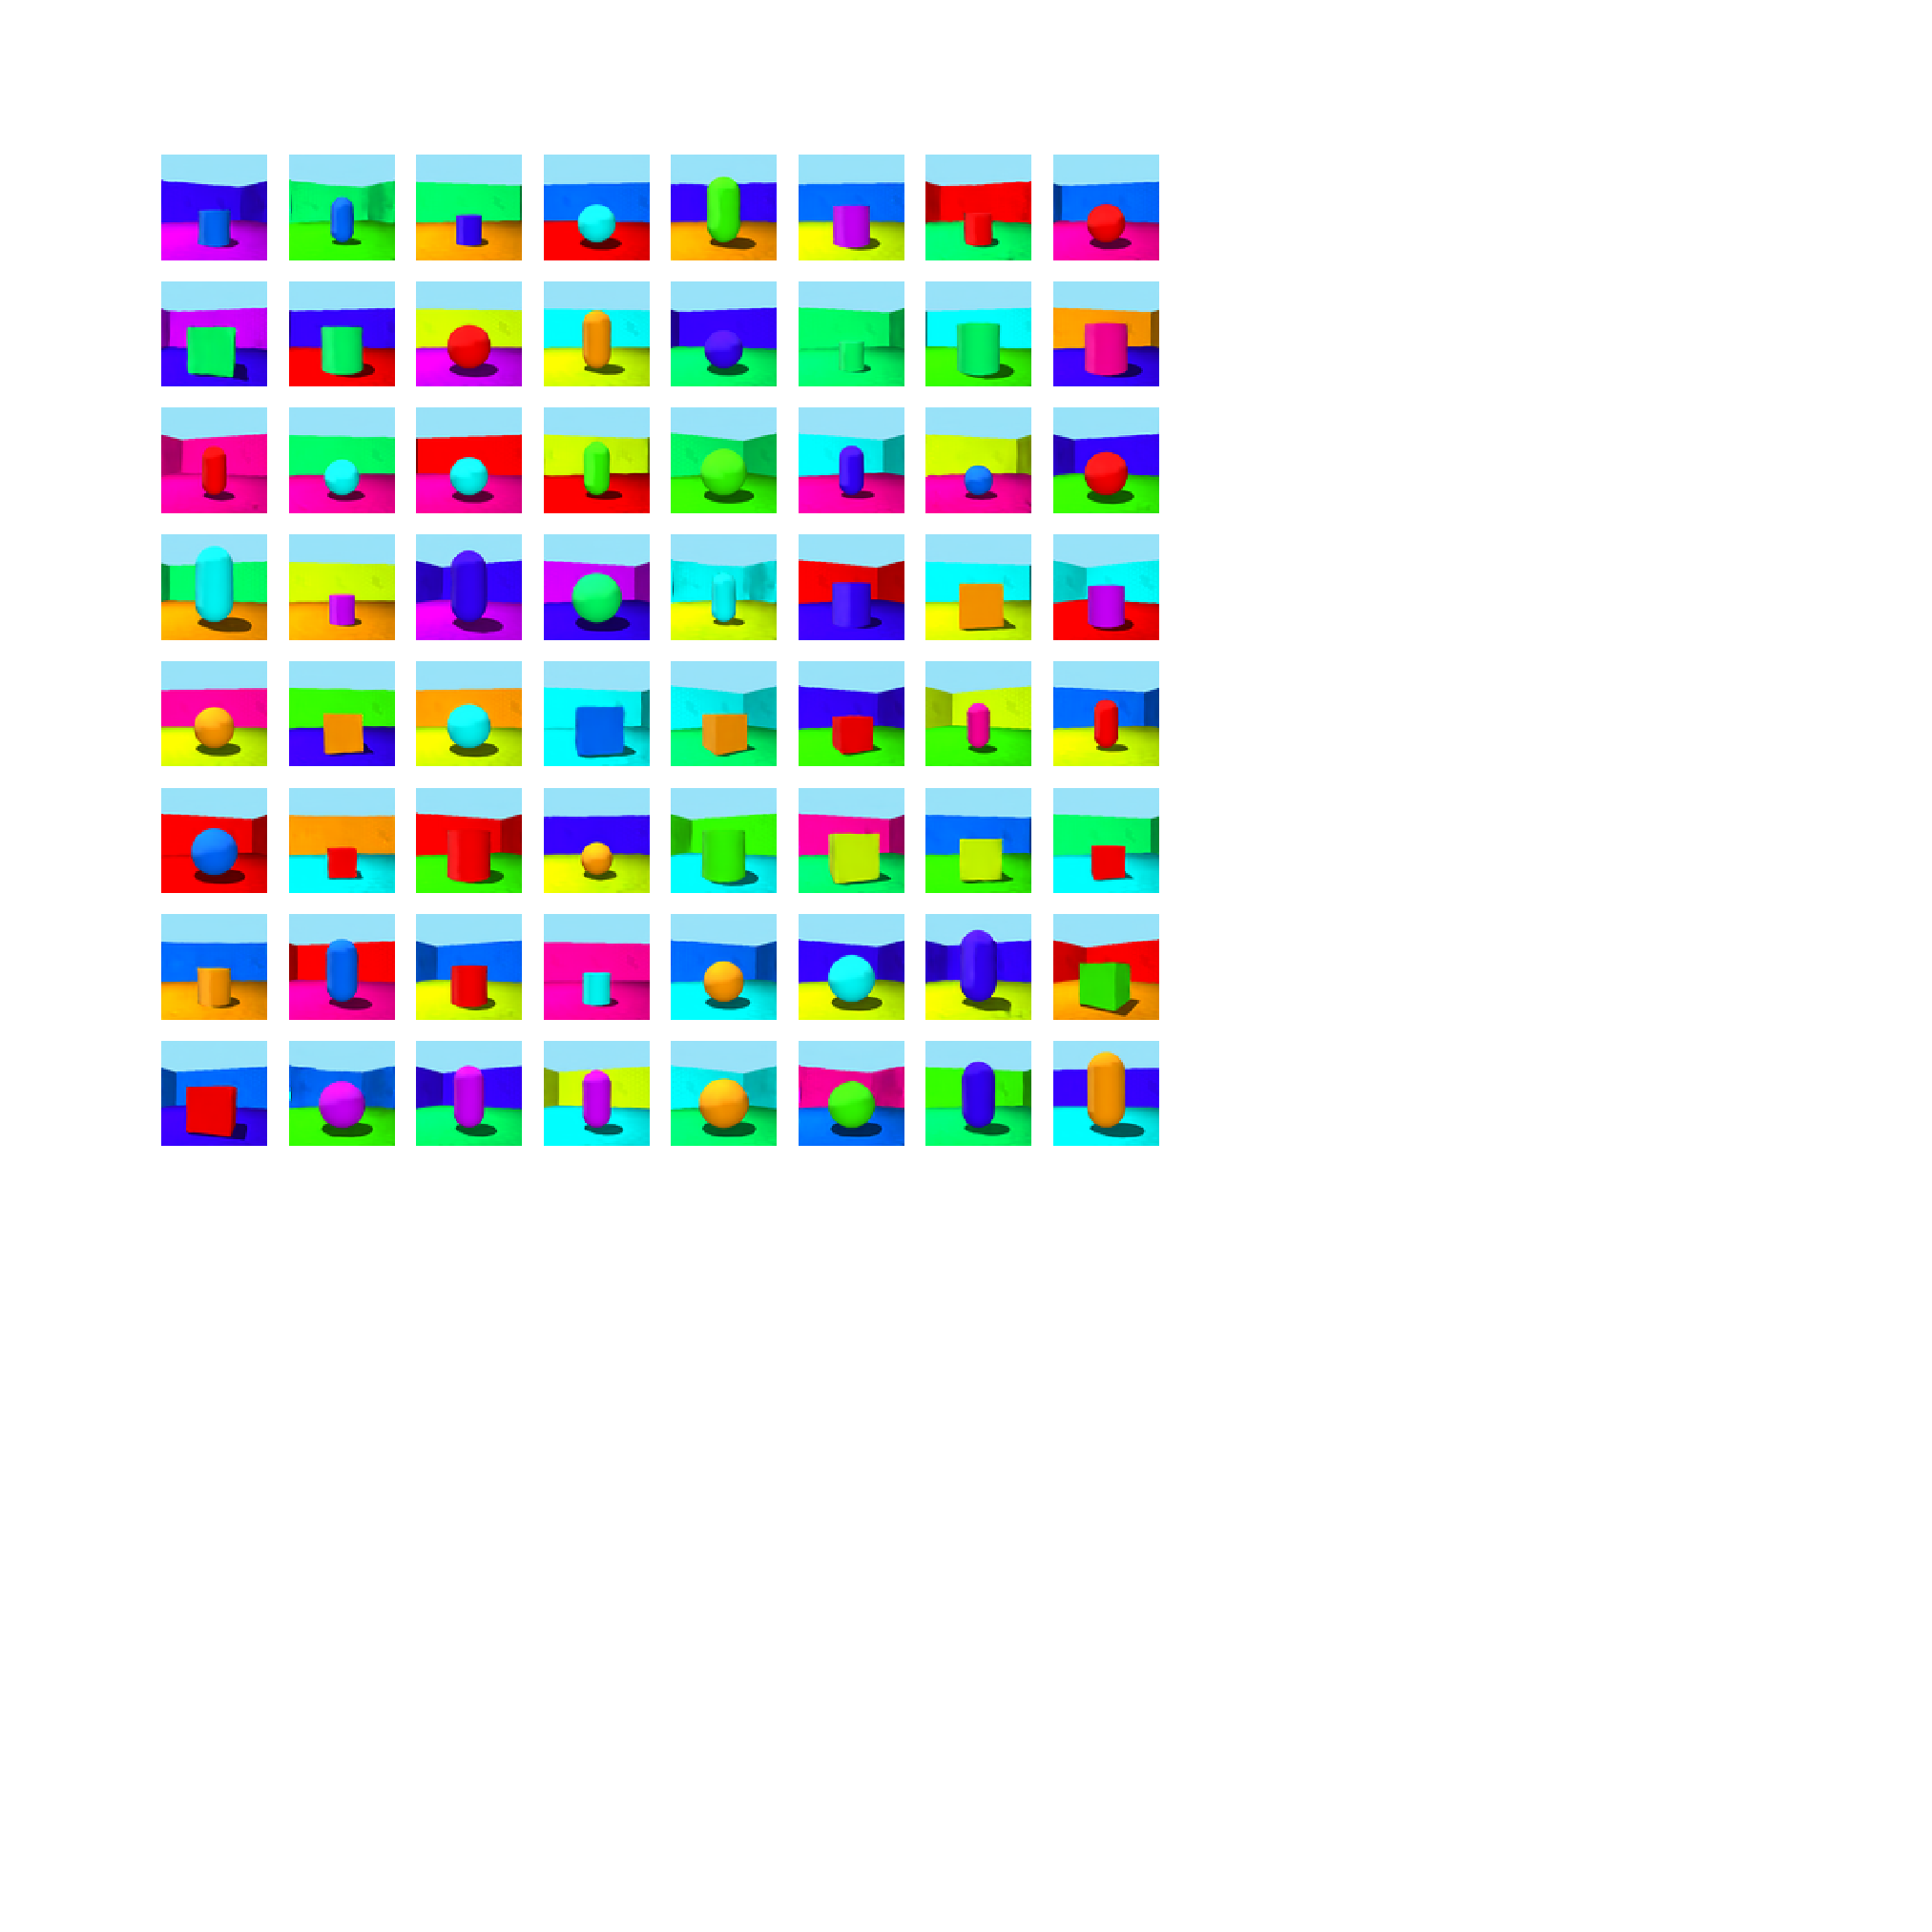

In [232]:
with torch.no_grad():
    gen = model.decode(H.to(model.device)).cpu()
util.show_imgs(gen, figsize=(9,9))
pass

In [233]:
# save_fig(f'{ds}_gen_periodic_hue_sampling')

3ds_gen_periodic_hue_sampling saved


In [235]:
# structured continuous sampling (based on MLE of periodic dims, and uniformly random for others)

H = torch.rand(G, S.size(-1))
mns, mxs = S.min(0)[0].unsqueeze(0), S.max(0)[0].unsqueeze(0)
H = (mxs-mns)*H + mns

for cname, dms in cdims.items():
    r, b = run.latent_params[cname]
    
    t = torch.rand(G)*2*np.pi
    
    H[:,dims] = torch.stack([r*torch.cos(t), r*torch.sin(t)], -1) + b.unsqueeze(0)

<IPython.core.display.Javascript object>


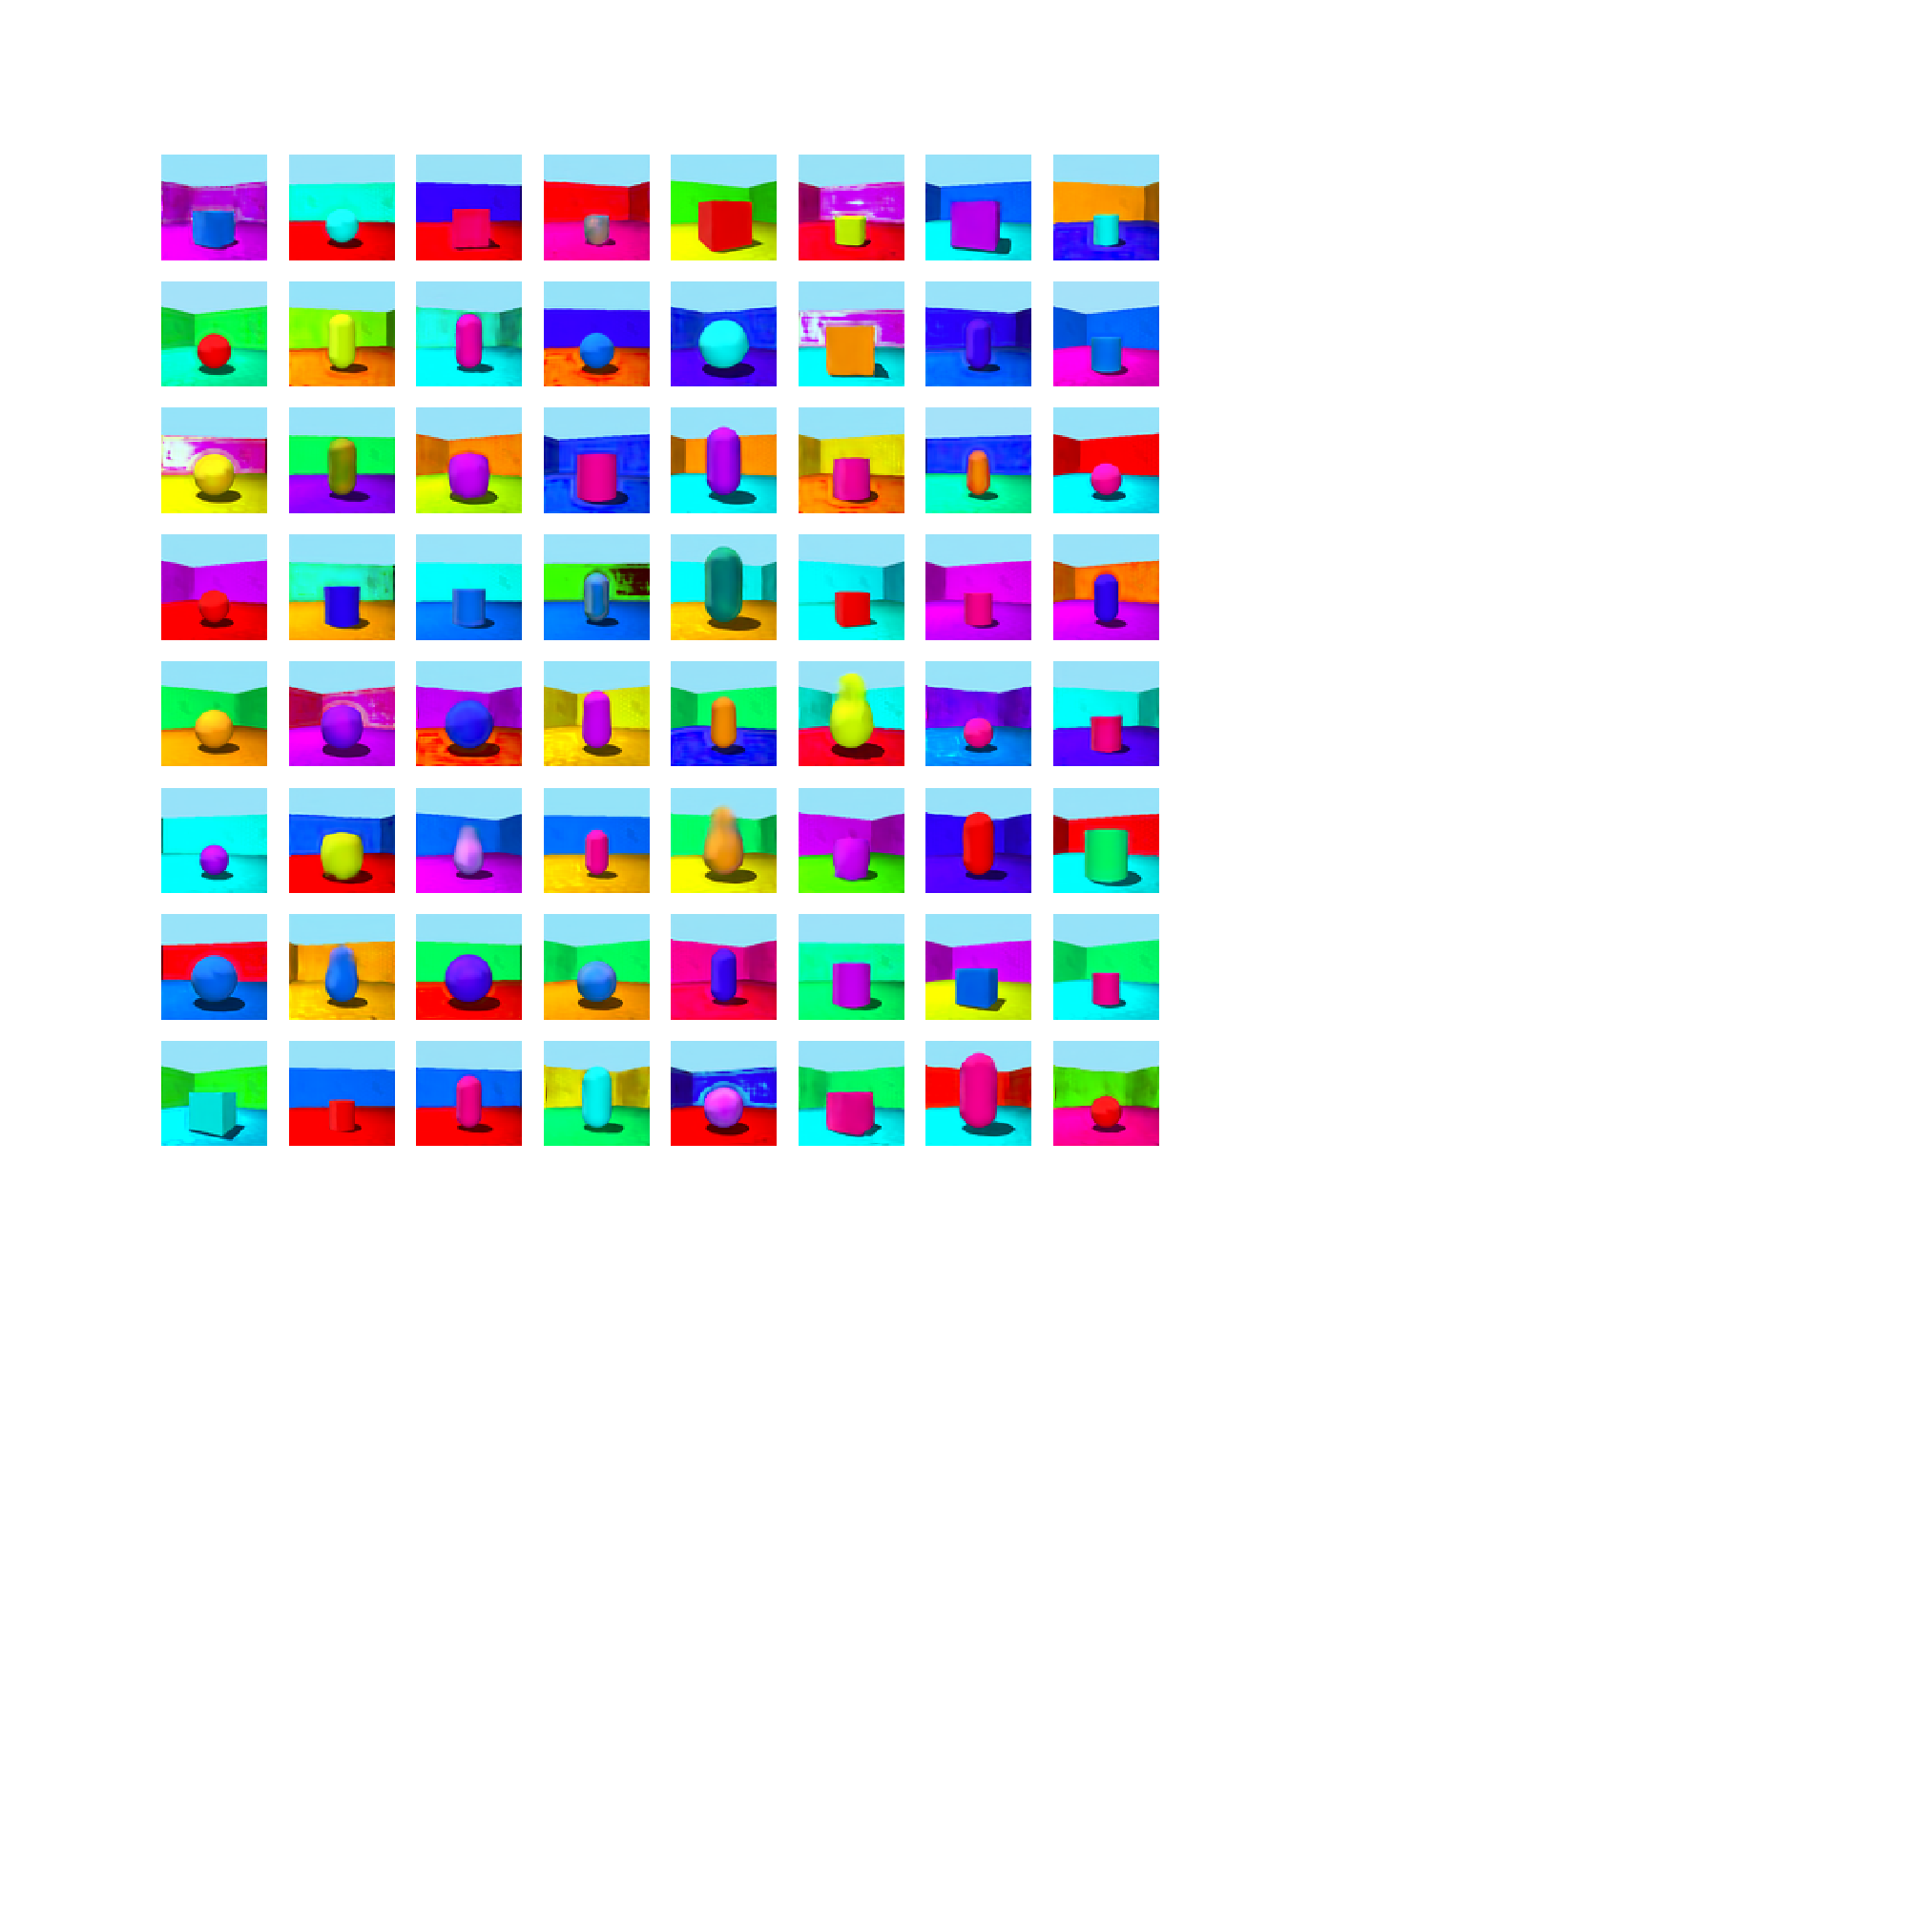

In [236]:
with torch.no_grad():
    sgen = model.decode(H.to(model.device)).cpu()
util.show_imgs(sgen,figsize=(9,9))
pass

In [237]:
# plt.savefig('figures/3ds_gen_circlefit_hue_sampling.png')

In [238]:
rname

'3ds-ae-12b1_0052-6286534-00_200429-030431'

In [239]:
# torch.save({'periodic_gen':gen.cpu(), 'circle_fit_gen':sgen.cpu()}, os.path.join(os.environ['FOUNDATION_SAVE_DIR'], rname, 'adv_gen.pth.tar'))

In [108]:
j = '/home/fleeb/jobs/job0047_200421-141428/job_4.sh'

In [110]:
*other, jdir, jexe = j.split('/')
jdir, jexe

('job0047_200421-141428', 'job_4.sh')

In [113]:
num, date = jdir.split('_')
num = int(num[3:])
num, date

(47, '200421-141428')

In [ ]:
def parse_jobpath(path):
    

In [114]:
h = 'slot1_1@g034.internal.cluster.is.localnet'

In [119]:
s, g = h.split('.')[0].split('@')
s = s.split('_')[-1]
f'{s}{g}'

'1g034'

In [120]:
from tabulate import tabulate

In [121]:
tabulate

<function tabulate.tabulate(tabular_data, headers=(), tablefmt='simple', floatfmt='g', numalign='decimal', stralign='left', missingval='', showindex='default', disable_numparse=False, colalign=None)>

In [127]:
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
          ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table, floatfmt='.10g'))

-----  ------  -------------
Sun    696000  1989100000
Earth    6371        5973.6
Moon     1737          73.5
Mars     3390         641.85
-----  ------  -------------


In [128]:
l = [1, 2, 3]
for x in l:
    if x % 2 == 0:
        l.remove(x)

In [129]:
l

[1, 3]